# Challenge

Attached to this email you'll find two CSV files. One with data on AS24 listings and another one describing the columns.
For the case study we want you to explore the data and investigate two questions:
1. Is it possible to predict the product tier from the information given in the other columns?
2. Is it possible to predict detail views from the information given in the other columns?

Please prepare a Jupyter Notebook to share your results and thoughts with us. We're not just looking at how well you can model the data but are also interested in your general approach and thoughts on the data and potential algorithms. So please document your code and communicate your results using markdown cells.

Deadline: 10/08/2020

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

%matplotlib inline

## Dataset & data cleaning

__article_id:__	unique article identifier   
__product_tier:__	premium status of the article  
__make_name:__	name of the car manufacturer  
__price:__	price of the article  
__first_zip_digit:__	first digit of the zip code of the region the article is offered in  
__first_registration_year:__	year of the first registration of the article  
__created_date:__	creation date of the listing  
__deleted_date:__	deletion date of the listing  
__search_views:__	number of times the article has been shown as a search result  
__detail_views:__	number of times the article has been clicked on  
__stock_days:__	Time in days between the creation of the listing and the deletion of the listing  
__ctr:__	Click through rate calculated as the quotient of detail_views over search_views!

In [2]:
#read dataset
df = pd.read_csv('AS24_Case_Study_Data.csv',sep=';')
df.head(10)

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224
5,361204569,Basic,Volkswagen,24890,6,2017,20.10.18,22.10.18,125.0,6.0,2,0.048
6,362784907,Basic,Fiat,2850,7,2008,08.11.18,09.11.18,172.0,4.0,1,0.022093023255813953
7,363942101,Basic,Renault,23740,2,2018,20.11.18,15.02.19,1499.0,99.0,87,0.06274182788525684
8,358875204,Basic,Renault,7850,6,2016,24.09.18,08.12.18,4329.0,133.0,75,0.030723030723030724
9,357547566,Basic,Mazda,13950,3,2016,08.09.18,10.10.18,2257.0,89.0,32,0.03943287549844927


1. Check out data types and null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78321 entries, 0 to 78320
Data columns (total 12 columns):
article_id                 78321 non-null int64
product_tier               78321 non-null object
make_name                  78321 non-null object
price                      78321 non-null int64
first_zip_digit            78321 non-null int64
first_registration_year    78321 non-null int64
created_date               78321 non-null object
deleted_date               78321 non-null object
search_views               78311 non-null float64
detail_views               78311 non-null float64
stock_days                 78321 non-null int64
ctr                        78297 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 7.2+ MB


2. Transform columns to an appropriate data type: search_views, detail_views and ctr throw errors due to null values

In [4]:
#transform variables

df["product_tier"] = df['product_tier'].astype('category')
df["make_name"] = df['make_name'].astype('category')

#Consider zip digit a categorical variable(similar to area's name)
df["first_zip_digit"] = df['first_zip_digit'].astype('category')

#Careful with the format
df["created_date"] = pd.to_datetime(df['created_date'],dayfirst=True)
df["deleted_date"] = pd.to_datetime(df['deleted_date'],dayfirst=True)

#df["search_views"] = df['search_views'].astype('int64')
#df["detail_views"] = df['detail_views'].astype('int64')
#df["ctr"] = df['ctr'].astype('float64')

#df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78321 entries, 0 to 78320
Data columns (total 12 columns):
article_id                 78321 non-null int64
product_tier               78321 non-null category
make_name                  78321 non-null category
price                      78321 non-null int64
first_zip_digit            78321 non-null category
first_registration_year    78321 non-null int64
created_date               78321 non-null datetime64[ns]
deleted_date               78321 non-null datetime64[ns]
search_views               78311 non-null float64
detail_views               78311 non-null float64
stock_days                 78321 non-null int64
ctr                        78297 non-null object
dtypes: category(3), datetime64[ns](2), float64(2), int64(4), object(1)
memory usage: 5.6+ MB


Check out the data points with null values on the search_views, detail_views or ctr columns and understand the reasons and how to handle them:
  
search_views and detail_views: 
  
- if one of the columns is null, then the other one has the same value
- if search_views==0, then detail_views=0 and ctr is null
- it is not related to the number of days in the market
- an expert of the data source should be asked about the reasons for the null values

ctr: 

- is null if search_views or detail_views are null as it is a quotient of both values(will be dropped as the reasons are not understood and its not a high number of data points)
- is null if search_views is equal to zero as it is the denominator of its formula(will be transformed to zero so we don't lose information)

In [5]:
#show rows with nulls in any column
df[df.isnull().any(axis=1)]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
6738,355684985,Basic,Volvo,5950,8,2009,2018-08-28,2018-08-28,0.0,0.0,0,NaN
10151,363161664,Basic,Renault,4950,3,2011,2018-11-12,2019-03-01,NaN,NaN,109,NaN
19983,360460901,Basic,Mercedes-Benz,105,7,2004,2018-10-12,2018-10-12,0.0,0.0,-1,NaN
21423,358837372,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN
26122,360460897,Basic,Mercedes-Benz,22445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN
27830,358837359,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN
28823,360460890,Basic,Mercedes-Benz,26445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN
38923,360471136,Basic,Audi,1500,2,2012,2018-10-12,2018-10-12,0.0,0.0,0,NaN
43222,360493605,Basic,Mercedes-Benz,37500,3,2002,2018-10-12,2018-10-12,0.0,0.0,0,NaN
47870,358837344,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN


In [6]:
#rows with "search_views"]==0 so we can see how this affect search_views  and ctr values
df[df["search_views"]==0]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
6738,355684985,Basic,Volvo,5950,8,2009,2018-08-28,2018-08-28,0.0,0.0,0,NaN
19983,360460901,Basic,Mercedes-Benz,105,7,2004,2018-10-12,2018-10-12,0.0,0.0,-1,NaN
26122,360460897,Basic,Mercedes-Benz,22445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN
28823,360460890,Basic,Mercedes-Benz,26445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN
38923,360471136,Basic,Audi,1500,2,2012,2018-10-12,2018-10-12,0.0,0.0,0,NaN
43222,360493605,Basic,Mercedes-Benz,37500,3,2002,2018-10-12,2018-10-12,0.0,0.0,0,NaN
52291,360460896,Basic,Mercedes-Benz,1194,7,2018,2018-10-12,2018-10-12,0.0,0.0,0,NaN
68584,360460887,Basic,Opel,16445,7,2009,2018-10-12,2018-10-12,0.0,0.0,0,NaN
69176,360460879,Basic,Mercedes-Benz,30445,7,2014,2018-10-12,2018-10-12,0.0,0.0,0,NaN
70772,364670935,Basic,Mercedes-Benz,2150,3,2002,2018-11-28,2018-11-29,0.0,0.0,1,NaN


In [7]:
#check if there is a relation between null values and created_date being equal to deleted_date
df[df.isnull().any(axis=1) &  (df['created_date']!= df['deleted_date'])]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
10151,363161664,Basic,Renault,4950,3,2011,2018-11-12,2019-03-01,NaN,NaN,109,NaN
60758,350270138,Basic,Ford,5450,2,2009,2018-07-20,2018-07-26,NaN,NaN,7,NaN
66498,349581063,Basic,Subaru,1,5,2006,2018-07-16,2018-09-11,NaN,NaN,57,NaN
70772,364670935,Basic,Mercedes-Benz,2150,3,2002,2018-11-28,2018-11-29,0.0,0.0,1,NaN
71854,363925615,Basic,Fiat,3795,5,2011,2018-11-20,2018-11-21,0.0,0.0,2,NaN


As the reasons for the null values on the search_views and detail_views are not understood and the amount of the data points with this issue is not large, these data points are removed from the dataset. However, the data points with null values on the ctr column due to search_views==0, will be transformed to zero in order to not lose information

In [8]:
#obtain index of "search_views"]==0 and change the corresponding ctr value
indexToBeChanged = df[df["search_views"]==0].index
df.at[indexToBeChanged, 'ctr'] = '0.0'
df[df["search_views"]==0]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
6738,355684985,Basic,Volvo,5950,8,2009,2018-08-28,2018-08-28,0.0,0.0,0,0.0
19983,360460901,Basic,Mercedes-Benz,105,7,2004,2018-10-12,2018-10-12,0.0,0.0,-1,0.0
26122,360460897,Basic,Mercedes-Benz,22445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,0.0
28823,360460890,Basic,Mercedes-Benz,26445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,0.0
38923,360471136,Basic,Audi,1500,2,2012,2018-10-12,2018-10-12,0.0,0.0,0,0.0
43222,360493605,Basic,Mercedes-Benz,37500,3,2002,2018-10-12,2018-10-12,0.0,0.0,0,0.0
52291,360460896,Basic,Mercedes-Benz,1194,7,2018,2018-10-12,2018-10-12,0.0,0.0,0,0.0
68584,360460887,Basic,Opel,16445,7,2009,2018-10-12,2018-10-12,0.0,0.0,0,0.0
69176,360460879,Basic,Mercedes-Benz,30445,7,2014,2018-10-12,2018-10-12,0.0,0.0,0,0.0
70772,364670935,Basic,Mercedes-Benz,2150,3,2002,2018-11-28,2018-11-29,0.0,0.0,1,0.0


In [9]:
#drop nulls
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78311 entries, 0 to 78320
Data columns (total 12 columns):
article_id                 78311 non-null int64
product_tier               78311 non-null category
make_name                  78311 non-null category
price                      78311 non-null int64
first_zip_digit            78311 non-null category
first_registration_year    78311 non-null int64
created_date               78311 non-null datetime64[ns]
deleted_date               78311 non-null datetime64[ns]
search_views               78311 non-null float64
detail_views               78311 non-null float64
stock_days                 78311 non-null int64
ctr                        78311 non-null object
dtypes: category(3), datetime64[ns](2), float64(2), int64(4), object(1)
memory usage: 6.2+ MB


In [10]:
#transform variables
df["search_views"] = df['search_views'].astype('int64')
df["detail_views"] = df['detail_views'].astype('int64')
#df["ctr"] = df['ctr'].astype('float64')

Check the ctr values that rise errors when trying to convert the column to a float data type. The values appear to be errors when inserting them in the dataset or format problems, either way, this should be asked to a data source expert. 

At this point, I try to check if ctr=detail_views/search_views so I can reintroduce the values myself but __the formula doesn't fit the rest of the dataset values(question to be asked)__. As the number of incidents is not high, I decide to remove these data points and not reintroduce values using ctr=detail_views/search_views as the formula used might be different from the one I assumed and its actual values are not so different from the formula.

In [11]:
#show the values that raise errors on transformation
df[pd.to_numeric(df['ctr'], errors='coerce').isnull()]['ctr']

849      27.624.309.392.265.100
1649      4.086.021.505.376.340
3885     30.066.815.144.766.100
4169      5.126.118.795.768.910
4410      1.485.148.514.851.480
                  ...          
71858     7.574.884.792.626.720
73055    23.525.280.898.876.400
73402     2.883.720.930.232.550
74868     4.199.855.177.407.670
76408    34.981.905.910.735.800
Name: ctr, Length: 82, dtype: object

In [12]:
df["ctr"] = pd.to_numeric(df['ctr'], errors='coerce')

#check if default ctr column differs from formula detail_views/search_views
df[((df["ctr"] - (df["detail_views"].astype('float64')/df["search_views"].astype('float64'))).abs()>0.01)]
#((df["ctr"] - (df["detail_views"].astype('float64')/df["search_views"].astype('float64'))).abs()>0.01).value_counts()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
1709,363539739,Basic,Caravans-Wohnm,7950,8,2000,2018-11-16,2018-11-19,72,22,3,0.290278
1876,355477820,Basic,Ford,24950,3,2017,2018-08-24,2018-11-23,2386,313,91,0.118392
2604,357115032,Basic,SEAT,19995,4,2016,2018-09-04,2018-09-04,2,1,0,0.475000
2719,364332880,Basic,Nissan,13750,5,2014,2018-11-24,2018-12-04,359,51,10,0.128210
2866,358877416,Basic,Honda,12950,9,2013,2018-09-24,2018-10-20,1654,332,26,0.181155
...,...,...,...,...,...,...,...,...,...,...,...,...
73901,357160278,Basic,Ford,14940,5,2015,2018-09-04,2018-09-08,198,21,4,0.095720
74216,348758042,Basic,Saab,3445,2,2003,2018-07-12,2018-07-17,249,35,5,0.126857
74847,360491694,Basic,Opel,14395,4,2015,2018-10-12,2018-10-13,9,2,1,0.211111
75361,347247274,Basic,BMW,5985,7,2002,2018-07-04,2018-07-07,283,62,3,0.208127


In [13]:
#drop rows with ctr values that could not be transformed
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78229 entries, 0 to 78320
Data columns (total 12 columns):
article_id                 78229 non-null int64
product_tier               78229 non-null category
make_name                  78229 non-null category
price                      78229 non-null int64
first_zip_digit            78229 non-null category
first_registration_year    78229 non-null int64
created_date               78229 non-null datetime64[ns]
deleted_date               78229 non-null datetime64[ns]
search_views               78229 non-null int64
detail_views               78229 non-null int64
stock_days                 78229 non-null int64
ctr                        78229 non-null float64
dtypes: category(3), datetime64[ns](2), float64(1), int64(6)
memory usage: 6.2 MB


In [14]:
df = df.reset_index(drop=True)
df.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,2018-07-24,2018-08-24,3091,123,30,0.037803
1,354412280,Basic,Mercedes-Benz,35950,4,2015,2018-08-16,2018-10-07,3283,223,52,0.067926
2,349572992,Basic,Mercedes-Benz,11950,3,1998,2018-07-16,2018-09-05,3247,265,51,0.081614
3,350266763,Basic,Ford,1750,6,2003,2018-07-20,2018-10-29,1856,26,101,0.014009
4,355688985,Basic,Mercedes-Benz,26500,3,2014,2018-08-28,2018-09-08,490,20,12,0.040816


With the general description of the dataset several issues can be detected:
- Values above 1 on the ctr (as mentioned before, I won't use the formula. Instead, the data points are dropped)
- Registration year having a max value of 2106 (only one outlier and I assume is an error and meant 2016, changed)
- Negative values on the stock_days (inconsistencies found and a second version of the column has been created out of the date columns, a question to be made)
- data points with a first registration year higher than created_date(not sure if this makes sense, it's left untouched but should be asked)
- data points with equal article id(different product_tier)

In [15]:
df.describe()

,article_id,price,first_registration_year,search_views,detail_views,stock_days,ctr
count,7.822900e+04,78229.000000,78229.000000,78229.000000,78229.000000,78229.000000,78229.000000
mean,3.574868e+08,15070.924683,2011.090785,2297.751000,93.489857,35.982999,0.047911
std,5.076810e+06,16380.390626,6.533207,6340.813907,228.108895,32.210112,0.327335
min,3.472324e+08,50.000000,1924.000000,0.000000,0.000000,-3.000000,0.000000
25%,3.536387e+08,5750.000000,2008.000000,367.000000,13.000000,10.000000,0.024083
50%,3.585479e+08,10909.000000,2013.000000,920.000000,36.000000,25.000000,0.037919
75%,3.614817e+08,18890.000000,2015.000000,2234.000000,94.000000,55.000000,0.058200
max,3.647040e+08,249888.000000,2106.000000,608754.000000,13926.000000,127.000000,87.500000


In [16]:
#inconsistent values on ctr
df[df['ctr'] > 1]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
29213,349556390,Basic,Peugeot,3950,4,2006,2018-07-16,2018-07-17,40,1,1,25.0
46118,364345922,Basic,Citroen,4750,3,2008,2018-11-24,2018-11-26,400,35,1,87.5


In [17]:
#filter out ctr values >1
df = df[df['ctr'] <= 1]

In [18]:
#show inconsistent values on first_registration_year
df[df['first_registration_year'] > 2020]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
36258,358877131,Basic,Opel,9250,7,2106,2018-09-24,2018-09-26,113,5,2,0.044248


In [19]:
#correct error on first_registration_year
indexToBeChanged = df[df['first_registration_year'] > 2020].index
df.at[indexToBeChanged, 'first_registration_year'] = 2016
df.loc[36258]

article_id                           358877131
product_tier                             Basic
make_name                                 Opel
price                                     9250
first_zip_digit                              7
first_registration_year                   2016
created_date               2018-09-24 00:00:00
deleted_date               2018-09-26 00:00:00
search_views                               113
detail_views                                 5
stock_days                                   2
ctr                                  0.0442478
Name: 36258, dtype: object

In [20]:
#Check for inconsistencies on stock days following the negative values clue

#df[(df['stock_days'] < 0) & (df['created_date']!= df['deleted_date'])]
df[(df['stock_days'] == 0) & (df['deleted_date']-df['created_date']> pd.Timedelta(days=1)) ]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
34192,363208310,Basic,Mercedes-Benz,44900,4,2018,2018-11-12,2018-11-14,116,4,0,0.032759
35471,364683959,Basic,Ford,3950,5,2009,2018-11-28,2018-12-01,453,51,0,0.112583
58552,358863459,Basic,Renault,6450,7,2014,2018-09-24,2018-09-26,43,0,0,0.000000
73919,358533132,Basic,Volvo,2900,6,2000,2018-09-20,2018-09-22,170,20,0,0.117647


In [21]:
df[(df['stock_days'] < 0) & (df['deleted_date']-df['created_date']> pd.Timedelta(days=1))]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
50082,359209773,Basic,Mercedes-Benz,9950,1,2009,2018-09-28,2018-09-30,186,2,-1,0.010753
56897,363915620,Basic,Renault,1395,1,2004,2018-11-20,2018-11-22,474,29,-1,0.061181


In [22]:
#create new stock days variable without inconsistencies
df['stock_days_v2']=(df['deleted_date'] - df['created_date']).dt.days.astype('int64')
df[((df['stock_days']-df['stock_days_v2']).abs()>1)]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,stock_days_v2
196,363896682,Basic,Mazda,13300,4,2016,2018-11-20,2019-01-05,3401,81,44,0.023817,46
481,363183009,Basic,Opel,10945,7,2013,2018-11-12,2018-11-24,221,0,15,0.000000,12
592,360473656,Basic,BMW,36900,7,2018,2018-10-12,2018-11-13,979,19,34,0.019408,32
872,362809203,Basic,Toyota,13495,3,2014,2018-11-08,2018-11-09,85,0,-1,0.000000,1
1251,348703957,Basic,Skoda,19999,8,2015,2018-07-12,2018-10-15,2641,144,93,0.054525,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77786,359257795,Basic,Opel,1999,3,2003,2018-09-28,2018-10-05,884,48,5,0.051584,7
77876,364333769,Basic,Toyota,5999,8,2013,2018-11-24,2018-12-05,302,5,13,0.016556,11
77992,351172657,Basic,Opel,1995,6,2003,2018-07-28,2018-08-03,202,33,4,0.155198,6
78069,355477561,Basic,Skoda,34950,7,2019,2018-08-24,2018-09-01,84,0,10,0.000000,8


In [23]:
#Check rows with registration year higher than the year of the post
df[df['first_registration_year'] > df['created_date'].dt.year]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,stock_days_v2
876,360080623,Basic,Opel,25599,7,2019,2018-10-08,2019-01-11,1166,14,95,0.012007,95
1568,364666768,Basic,Volkswagen,34950,5,2019,2018-11-28,2019-01-12,2379,102,45,0.042875,45
4093,360766204,Basic,Skoda,30550,5,2019,2018-10-16,2019-02-14,1254,43,121,0.034290,121
4737,360491439,Basic,Volkswagen,32900,1,2019,2018-10-12,2019-01-17,445,8,97,0.016225,97
6657,360790269,Basic,Ford,28570,7,2019,2018-10-16,2019-02-12,202,2,120,0.009901,119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74503,364666765,Basic,Volkswagen,31450,5,2019,2018-11-28,2019-01-08,1467,68,41,0.046353,41
74831,361507076,Basic,Suzuki,19950,6,2019,2018-10-24,2019-01-23,1176,45,91,0.036352,91
74936,361505936,Basic,Ford,30358,1,2019,2018-10-24,2019-01-18,600,14,86,0.023333,86
77599,359772338,Basic,Mercedes-Benz,1450,5,2020,2018-10-04,2019-02-05,100439,3065,123,0.030516,124


In [24]:
#Check and understand article_id repetitions. All the cases have different product_tier between them
df[(df.duplicated(subset=['article_id','product_tier'], keep=False))].count()

article_id                 0
product_tier               0
make_name                  0
price                      0
first_zip_digit            0
first_registration_year    0
created_date               0
deleted_date               0
search_views               0
detail_views               0
stock_days                 0
ctr                        0
stock_days_v2              0
dtype: int64

In [25]:
df.describe()

,article_id,price,first_registration_year,search_views,detail_views,stock_days,ctr,stock_days_v2
count,7.822700e+04,78227.000000,78227.000000,78227.000000,78227.000000,78227.000000,78227.000000,78227.000000
mean,3.574868e+08,15071.198780,2011.089739,2297.804121,93.491787,35.983893,0.046475,35.982487
std,5.076736e+06,16380.510197,6.524460,6340.886196,228.111475,32.210038,0.037725,32.209941
min,3.472324e+08,50.000000,1924.000000,0.000000,0.000000,-3.000000,0.000000,0.000000
25%,3.536387e+08,5750.000000,2008.000000,367.500000,13.000000,10.000000,0.024083,10.000000
50%,3.585479e+08,10909.000000,2013.000000,920.000000,36.000000,25.000000,0.037918,25.000000
75%,3.614817e+08,18891.500000,2015.000000,2234.000000,94.000000,55.000000,0.058199,55.000000
max,3.647040e+08,249888.000000,2020.000000,608754.000000,13926.000000,127.000000,1.000000,126.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78227 entries, 0 to 78228
Data columns (total 13 columns):
article_id                 78227 non-null int64
product_tier               78227 non-null category
make_name                  78227 non-null category
price                      78227 non-null int64
first_zip_digit            78227 non-null category
first_registration_year    78227 non-null int64
created_date               78227 non-null datetime64[ns]
deleted_date               78227 non-null datetime64[ns]
search_views               78227 non-null int64
detail_views               78227 non-null int64
stock_days                 78227 non-null int64
ctr                        78227 non-null float64
stock_days_v2              78227 non-null int64
dtypes: category(3), datetime64[ns](2), float64(1), int64(7)
memory usage: 9.3 MB


## Data exploration and visualization

Show the distribution of the product tier variables. It is shown that it's not equally distributed as the Basic value represents more than 90% . This issue will affect the performance of prediction models as its introducing bias and even a model predicting always "Basic" will end up with good accuracy(not the only metric to be check in this kind of cases)

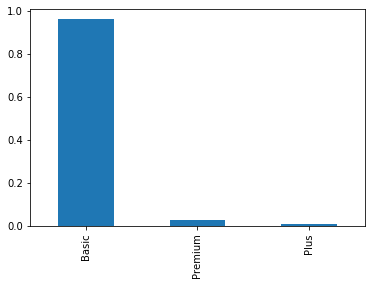

In [27]:
aux = df['product_tier'].value_counts()
auxiliar = (aux/aux.sum()).plot(kind='bar')

Check search_views distribution discarding outliers in order to have a detailed view of the skewness and shape

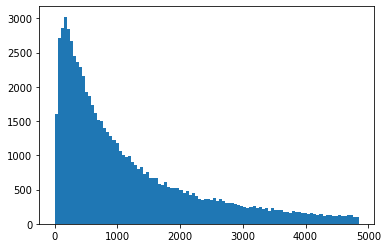

In [28]:
threshold = df['search_views'].quantile(0.9)
plt.hist(df[df['search_views']<threshold]['search_views'], bins = 100)
plt.show()

Check if the product_tier distribution changes based on the zip area but appears to be that the unequal distribution is kept among them.

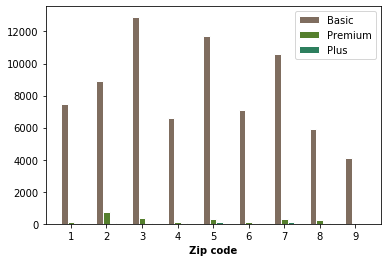

In [29]:
N = df['first_zip_digit'].nunique()

barWidth = 0.35

basic_Zip = df[df['product_tier'] == "Basic"]['first_zip_digit'].astype('int64').value_counts().sort_index().to_numpy() 
premium_Zip = df[df['product_tier'] == "Premium"]['first_zip_digit'].astype('int64').value_counts().sort_index().to_numpy() 
plus_Zip = df[df['product_tier'] == "Plus"]['first_zip_digit'].astype('int64').value_counts().sort_index().to_numpy() 

r1 = np.linspace(0, 15, len(basic_Zip))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
plt.bar(r1, basic_Zip, color='#7f6d5f', width=barWidth, edgecolor='white', label='Basic')
plt.bar(r2, premium_Zip, color='#557f2d', width=barWidth, edgecolor='white', label='Premium')
plt.bar(r3, plus_Zip, color='#2d7f5e', width=barWidth, edgecolor='white', label='Plus')
 
plt.xlabel('Zip code', fontweight='bold')
plt.xticks([r + barWidth for r in r1], ['1', '2', '3', '4', '5', '6', '7', '8', '9'])
 
# Create legend & Show graphic
plt.legend()
plt.show()



Checking what kind of cars are posted more

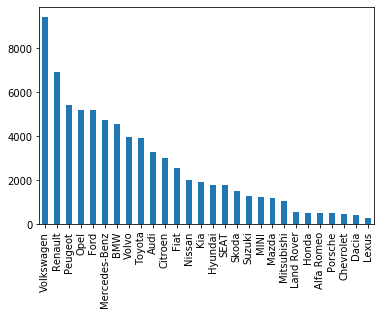

In [30]:
threshold = 300
mask = df['make_name'].value_counts()>threshold
df['make_name'].value_counts()[mask].plot(kind='bar')

Check if there is a relation between how many cars from a manufacturer are posted and the "average price of the brand". It is shown that the brands with more posts in the platform don't have a high average price

<function matplotlib.pyplot.show(*args, **kw)>

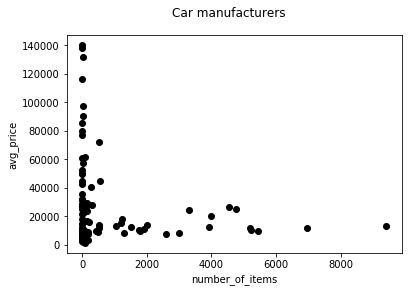

In [31]:
df1 = df.groupby('make_name', as_index=False)['price'].agg(['mean', 'count']).add_suffix('').reset_index()
df1 = df1.rename(columns={'mean': 'price'})

df1['price'].max() #139900.0
plt.plot(df1['count'], df1['price'], 'o', color='black')
plt.suptitle('Car manufacturers')
plt.xlabel('number_of_items')
plt.ylabel('avg_price')
plt.show

Check correlation between numerical variables. There is a meaningful relation between:

- search views and detail views
- first registration year and price
- first registration year and views(detail and search)
- stock days and views(detail and search)

Having detail views involved in these correlations could let us think that developing a regression model could be achievable.

In [32]:
corr = df.select_dtypes(include=['float64','int64'])
corr = corr.drop(['article_id', 'stock_days'], axis=1)
corr.corr()

,price,first_registration_year,search_views,detail_views,ctr,stock_days_v2
price,1.000000,0.312312,0.003036,0.028905,0.004027,0.085841
first_registration_year,0.312312,1.000000,-0.110343,-0.122741,-0.053877,0.082013
search_views,0.003036,-0.110343,1.000000,0.835642,-0.058647,0.271683
detail_views,0.028905,-0.122741,0.835642,1.000000,0.104803,0.281678
ctr,0.004027,-0.053877,-0.058647,0.104803,1.000000,-0.149392
stock_days_v2,0.085841,0.082013,0.271683,0.281678,-0.149392,1.000000


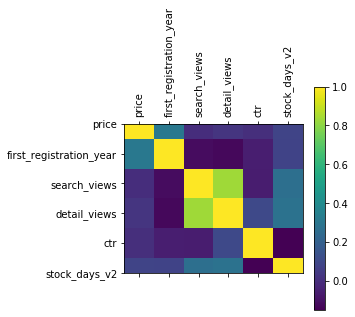

In [33]:
plt.matshow(corr.corr())
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

Check if the distribution of the price changes based on the product tier but It shows similar dist.

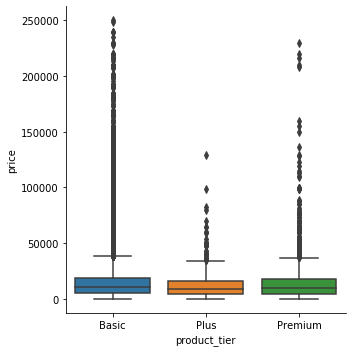

In [34]:
sns.catplot(x='product_tier', y='price', kind="box", data=df)

Make sure that the stock days variable created has the same distribution as the original

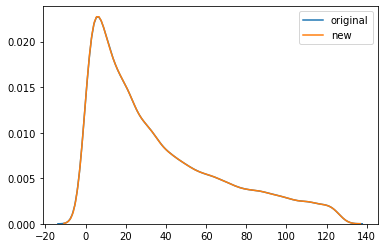

In [35]:
sns.kdeplot(df['stock_days'], label="original")
sns.kdeplot(df['stock_days_v2'], label="new")
plt.legend();

Show how the number of articles posted changes over time(Months). If we had different years and the time period was longer, patterns such as trends and seasonality could be spotted.

2018-07-04 00:00:00


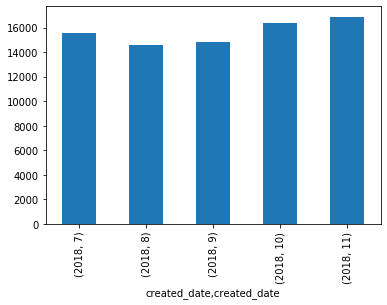

In [36]:
df['created_date'].groupby([df['created_date'].dt.year, df['created_date'].dt.month]).count().plot(kind="bar")
print(df["created_date"].min())
#print(df["created_date"].max())

## Prediction models

### Product tier

Difficult due to the unequal distribution in the dataset

In [37]:
#drop id and original stock_days as they are not useful for the models
train = df.drop(['article_id','stock_days'], axis=1)

#transform date variables so they can be used by the model
ref = df[['deleted_date','created_date']].min().min()
train['deleted_date'] = 12 * (df['deleted_date'].dt.year - ref.year) + (df['deleted_date'].dt.month - ref.month)
train['created_date'] = 12 * (df['created_date'].dt.year - ref.year) + (df['created_date'].dt.month - ref.month)

#Pull apart the variable to be predicted
y = train['product_tier']
train = train.drop('product_tier', axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78227 entries, 0 to 78228
Data columns (total 10 columns):
make_name                  78227 non-null category
price                      78227 non-null int64
first_zip_digit            78227 non-null category
first_registration_year    78227 non-null int64
created_date               78227 non-null int64
deleted_date               78227 non-null int64
search_views               78227 non-null int64
detail_views               78227 non-null int64
ctr                        78227 non-null float64
stock_days_v2              78227 non-null int64
dtypes: category(2), float64(1), int64(7)
memory usage: 8.0 MB


In [38]:
#train and test data
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.3,random_state=101)

In [39]:
#define pipeline to preprocess data. Onehotencoders for categorical variables and normalization for numeric data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = train.select_dtypes(exclude=['category']).columns
categorical_features = train.select_dtypes(include=['category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Different classification algorithms could have been tested and use a grid search to optimize parameters but the random classifier already gave good results and I guess the objective of the challenge was to realize that the data was biased and how this would affect the model performance.

In [40]:
#define complete pipeline to preprocess data, train the model and make predictions

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [41]:
#train the classifier
rf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['price', 'first_registration_year', 'created_date', 'deleted_date',
       'search_views', 'detail_views', 'ctr', 'stock_days_v2'],
      dtype='object...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_

In [42]:
y_pred = rf.predict(X_test)


This confusion matrix shows exactly what we expected. The model is predicting "Basic" most of the time and that gives a relatively good performance. However, details such as the Premium recall and Plus metrics show that the model is not working as good as we could desire. Another detail is that the precision value for Premium(or "Plus") is kind of high due the fact that out of all "Premium" predictions, most are correct but the model is missing many of real "Premium" and that's why the recall is low.

This problem could be solve by collecting more data, subsampling(difficult to not introduce bias or not change the other variables distribution) or generate synthetic data similar to samples.

In [43]:
print(metrics.confusion_matrix(y_test, y_pred, labels=["Basic", "Premium", "Plus"]))
print(metrics.classification_report(y_test, y_pred, labels=["Basic", "Premium", "Plus"]))
print(metrics.accuracy_score(y_test, y_pred))

[[22537    57     0]
 [  482   220     0]
 [  165     7     1]]
              precision    recall  f1-score   support

       Basic       0.97      1.00      0.98     22594
     Premium       0.77      0.31      0.45       702
        Plus       1.00      0.01      0.01       173

    accuracy                           0.97     23469
   macro avg       0.92      0.44      0.48     23469
weighted avg       0.97      0.97      0.96     23469

0.9697047168605394


### Detail views

Use correlation matrix to decide variables to use in a regression model

In [44]:
#drop id and original stock_days as they are not useful for the models
train = df.drop(['article_id','stock_days'], axis=1)

#transform date vars
ref = df[['deleted_date','created_date']].min().min()
train['deleted_date'] = 12 * (df['deleted_date'].dt.year - ref.year) + (df['deleted_date'].dt.month - ref.month)
train['created_date'] = 12 * (df['created_date'].dt.year - ref.year) + (df['created_date'].dt.month - ref.month)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78227 entries, 0 to 78228
Data columns (total 11 columns):
product_tier               78227 non-null category
make_name                  78227 non-null category
price                      78227 non-null int64
first_zip_digit            78227 non-null category
first_registration_year    78227 non-null int64
created_date               78227 non-null int64
deleted_date               78227 non-null int64
search_views               78227 non-null int64
detail_views               78227 non-null int64
ctr                        78227 non-null float64
stock_days_v2              78227 non-null int64
dtypes: category(3), float64(1), int64(7)
memory usage: 8.1 MB


Check if the new date values show a correlation that could be helpful in the next regression model

In [45]:
corr = train.drop(['make_name','first_zip_digit'], axis=1)
corr.corr()

,price,first_registration_year,created_date,deleted_date,search_views,detail_views,ctr,stock_days_v2
price,1.000000,0.312312,0.015065,0.059224,0.003036,0.028905,0.004027,0.085841
first_registration_year,0.312312,1.000000,0.026625,0.069491,-0.110343,-0.122741,-0.053877,0.082013
created_date,0.015065,0.026625,1.000000,0.786091,0.028273,0.036979,-0.036881,0.001060
deleted_date,0.059224,0.069491,0.786091,1.000000,0.181357,0.194350,-0.115541,0.581918
search_views,0.003036,-0.110343,0.028273,0.181357,1.000000,0.835642,-0.058647,0.271683
detail_views,0.028905,-0.122741,0.036979,0.194350,0.835642,1.000000,0.104803,0.281678
ctr,0.004027,-0.053877,-0.036881,-0.115541,-0.058647,0.104803,1.000000,-0.149392
stock_days_v2,0.085841,0.082013,0.001060,0.581918,0.271683,0.281678,-0.149392,1.000000


Here we play with the variables that will be used by the regression models in order to make it more simple, better at generalization and improve performance

In [46]:
y = train['detail_views']
#train = train.drop('detail_views', axis=1)
train = train.drop(['make_name','first_zip_digit','product_tier','detail_views'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78227 entries, 0 to 78228
Data columns (total 7 columns):
price                      78227 non-null int64
first_registration_year    78227 non-null int64
created_date               78227 non-null int64
deleted_date               78227 non-null int64
search_views               78227 non-null int64
ctr                        78227 non-null float64
stock_days_v2              78227 non-null int64
dtypes: float64(1), int64(6)
memory usage: 7.3 MB


In [47]:
#train and test data
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.3,random_state=101)

In [48]:
#transform data: onehotencoders and normalization. Onehotencoder is kept in the pipeline because categorical var 
#               might be included
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = train.select_dtypes(exclude=['category']).columns
categorical_features = train.select_dtypes(include=['category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#two models are defined so we can compare performance
rRandom = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators = 10, random_state = 0))])
rLinear = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

In [49]:
#training
rLinear.fit(X_train, y_train)
rRandom.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['price', 'first_registration_year', 'created_date', 'deleted_date',
       'search_views', 'ctr', 'stock_days_v2'],
      dtype='object')),
                                                 ('cat',
                                                  OneH...
                                   verbose=False)),
                ('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',


In both, metrics and plots, can be seen that the random forest regressor has better performance and its MAE and MSE are quite lower. On the plots, the Random predictions fit better the line, but it is shown that its predictions on data with a high number of detail_views are not accurate.

In [50]:
y_predLinear = rLinear.predict(X_test)
y_predRandom = rRandom.predict(X_test)
print('LINEAR regresion')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predLinear))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predLinear))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predLinear)))

print('RANDOM regresion')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predRandom))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predRandom))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predRandom)))

LINEAR regresion
Mean Absolute Error: 38.5900252401143
Mean Squared Error: 11636.212480297962
Root Mean Squared Error: 107.87127736472745
RANDOM regresion
Mean Absolute Error: 3.5576121692445355
Mean Squared Error: 3181.463898760067
Root Mean Squared Error: 56.404467010690446


In [51]:
#check how important are the different variables in the linear regression model

#NOT WORKING IF CATEGORICAL VARIABLES ARE INVOLVED DUE TO ONEHOTENCODER
coeff_df = pd.DataFrame(rLinear.named_steps['regressor'].coef_, X_test.columns, columns=['Coefficient'])
coeff_df

,Coefficient
price,7.917964
first_registration_year,-10.142068
created_date,1.492919
deleted_date,4.230948
search_views,186.919707
ctr,37.144902
stock_days_v2,17.679582


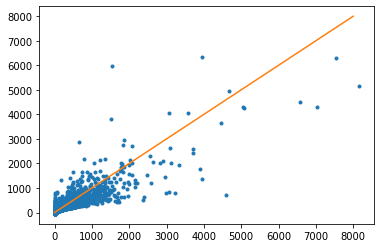

In [52]:
plt.plot(y_test, y_predLinear, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 8000, 100)
y = x
plt.plot(x, y)
plt.show()

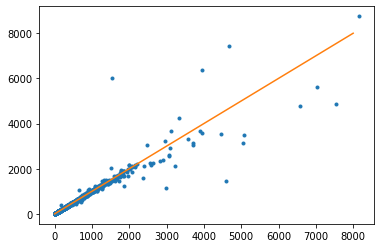

In [53]:
plt.plot(y_test, y_predRandom, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 8000, 100)
y = x
plt.plot(x, y)
plt.show()